In [1]:
import time
import glob as glob
from zipfile import ZipFile
from bs4 import BeautifulSoup
import dateutil.parser as dparser
import datetime
import pandas as pd
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sortedcontainers import SortedSet
import statistics
import operator
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Set types and drop useless data

In [2]:
df = pd.read_csv('/home/shane/Documents/thesis/output/final/failures2.csv', parse_dates=['timestamp_dir'])
df['operational_pct'] = df['operational_pct'].astype('float') * 100
df['partial_pct'] = df['partial_pct'].astype('float') * 100
df['major_pct'] = df['major_pct'].astype('float') * 100
df['maint_pct'] = df['maint_pct'].astype('float') * 100
df.drop(['timestamp_site'], axis=1, inplace=True)
df.dropna(inplace=True)

## Mean aggregation by hour

In [3]:
df_grp = df.reset_index().groupby(['service','timestamp_dir'], as_index=False).agg({'operational_pct': 'mean', 'partial_pct': 'mean', 'major_pct': 'mean', 'maint_pct': 'mean'})
df_grp.describe()

,operational_pct,partial_pct,major_pct,maint_pct
count,449279.000000,449279.000000,449279.000000,449279.000000
mean,95.619856,4.279417,0.099078,0.001648
std,19.193069,19.001882,2.468380,0.310195
min,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,0.000000,0.000000
50%,100.000000,0.000000,0.000000,0.000000
75%,100.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000


In [4]:
# timeseries['operational_pct'].columns.tolist()
cols = ['Access (Atlassian)',
 'Airbnb',
 'Amazon',
 'Bitbucket',
 'Blogger',
 'Cloudflare',
 'Confluence',
 'Developers (Atlassian)',
 'Discord',
 'Facebook',
 'Foursquare',
 'GitHub',
 'Gmail',
 'Google Cloud',
 'Hotmail',
 'Jira Align',
 'Jira Core',
 'Jira Service Desk',
 'Jira Software',
 'LinkedIn',
 'LiveJournal',
 'Lyft',
 'Netflix',
 'Ning',
 'Opsgenie',
 'Partners (Atlassian)',
 'PayPal',
 'Pinterest',
 'Reddit',
 'Skype',
 'Slack',
 'Snapchat',
 'Spotify',
 'Statuspage',
 'Support (Atlassian)',
 'Trello',
 'Tumblr',
 'Twitter',
 'Typepad',
 'Yahoo! Mail',
 'YouTube',
 'Zynga']

In [36]:
grouped = df.sort_values('timestamp_dir').groupby('service')

In [37]:
def get_state_changes(what, dee_eff):
    state_changes = []
    for name, group in dee_eff:
        sc_ts = group[group['timestamp_dir'].diff() > datetime.timedelta(days=2)].timestamp_dir.tolist()
        sc_list = []
            
        sc_list = group[group[col].diff() > 0].timestamp_dir.tolist()
        sc_set = SortedSet(sc_list)

        x = group.groupby(['timestamp_dir'])[col].first()
        if x[1] > 0:
            sc_set.add(x.index[0])
        state_changes.append([name, len(group), sc_set, sc_ts])
    return state_changes

In [38]:
def get_timedeltas(state_changes):
    mtbsc_stats = []
    for group in state_changes:
        service = group[0]
        num_records = group[1]
        changes = group[2]
        time_gaps = group[3]
        num_changes = len(changes)-1
        mtbsc = []
        try:
            previous = changes.pop(0)
        except:
            mtbsc_stats.append([service, num_records, num_changes, round(num_changes/num_records*100,2), np.nan])
            continue

        for x in range(0, len(changes)):
            current = changes.pop(0)
            there_is_a_time_gap = False
            for tg in time_gaps:
                if previous < tg and current > tg:
#                     print(service, '\t', previous, '\t', tg, '\t', current, '\t', current - previous)
                    there_is_a_time_gap = True
                    break
            if there_is_a_time_gap:
                previous = current
                continue
            mtbsc.append(current - previous)
            previous = current
        mtbsc_mean = pd.to_timedelta(mtbsc).mean()
        mtbsc_stats.append([service, num_records, num_changes, round(num_changes/num_records*100,2), mtbsc_mean])
    return mtbsc_stats

In [39]:
col = 'partial_pct'
mtbf_all = get_state_changes(col, grouped)
mean_mtbf_po = get_timedeltas(mtbf_all)
df_mtbf_all = pd.DataFrame(mean_mtbf_po, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_all['mtbf_po'] = round(df_mtbf_all['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)

col = 'major_pct'
mtbf_mo = get_state_changes(col, grouped)
mean_mtbf_mo = get_timedeltas(mtbf_mo)
df_mtbf_mo = pd.DataFrame(mean_mtbf_mo, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_mo['mtbf_mo'] = round(df_mtbf_mo['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbf_all['mtbf_mo'] = df_mtbf_mo['mtbf_mo']

col = 'maint_pct'
mtbf_ma = get_state_changes(col, grouped)
mean_mtbf_ma = get_timedeltas(mtbf_ma)
df_mtbf_ma = pd.DataFrame(mean_mtbf_ma, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_ma['mtbf_ma'] = round(df_mtbf_ma['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbf_all['mtbf_ma'] = df_mtbf_ma['mtbf_ma']

mtbf_plot = df_mtbf_all.copy()
mtbf_plot.drop(['records','state_changes','pct_state_changes','mean_td'], axis=1, inplace=True)

mtbf_plot['service'] = cols
mtbf_plot
print(mtbf_plot.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                service &  mtbf\_po &  mtbf\_mo &  mtbf\_ma \\
\midrule
     Access (Atlassian) &      NaN &      NaN &      NaN \\
                 Airbnb &     1.06 &    13.52 &      NaN \\
                 Amazon &     0.14 &     0.83 &      NaN \\
              Bitbucket &     6.28 &     2.19 &    16.96 \\
                Blogger &    91.14 &      NaN &      NaN \\
             Cloudflare &     0.14 &    36.02 &    28.00 \\
             Confluence &    15.95 &      NaN &      NaN \\
 Developers (Atlassian) &    22.97 &      NaN &      NaN \\
                Discord &    10.46 &      NaN &      NaN \\
               Facebook &    11.43 &      NaN &      NaN \\
             Foursquare &      NaN &      NaN &      NaN \\
                 GitHub &     7.52 &    36.62 &      NaN \\
                  Gmail &    34.38 &      NaN &      NaN \\
           Google Cloud &     6.09 &      NaN &      NaN \\
                Hotmail &    28.14 &      NaN &      NaN 

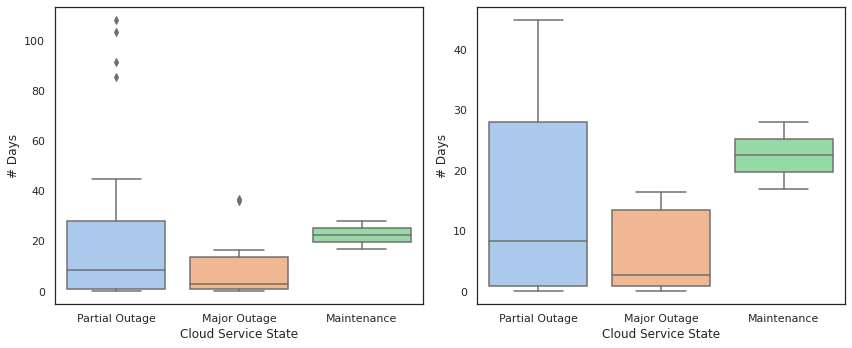

In [51]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set(style='white')
fig, ax = plt.subplots(1,2)
ax1 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(mtbf_plot.set_index('service')), ax=ax[0])
ax2 = sns.boxplot(x='variable', y='value', palette='pastel', showfliers=False, data=pd.melt(mtbf_plot.set_index('service')), ax=ax[1])
ax1.set(title='', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='# Days')
ax2.set(title='', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Cloud Service State', ylabel='# Days')
fig.tight_layout()
plt.savefig('/home/shane/Documents/thesis/output/plots/boxes_mtbf.pdf')

In [ ]:
# print(round(mtbf_plot.describe(), 2).to_latex())
print((mtbf_plot['mtbf_po'].sum() - 85.31 - 91.14 - 103.25 - 107.90) / 28)
print((mtbf_plot['mtbf_mo'].sum() - 36.02 - 36.62) / 11)
print(mtbf_plot.median())
mtbf_plot.describe()

In [ ]:
mtbf_plot2 = mtbf_plot.drop(['mtbf_ma'], axis=1)
mtbf_plot2['mtbf_po'].corr(mtbf_plot2['mtbf_mo'])

In [ ]:
print(mtbf_plot[mtbf_plot['mtbf_po'] > mtbf_plot['mtbf_po'].mean()].count()/.42, '\n')
print(mtbf_plot[mtbf_plot['mtbf_mo'] > mtbf_plot['mtbf_mo'].mean()].count()/.42, '\n')
print(mtbf_plot[mtbf_plot['mtbf_ma'] > mtbf_plot['mtbf_ma'].mean()].count()/.14, '\n')

# Get self-/user-reported dataframes

### Self-Reported

In [41]:
df_tmp = df.drop(df[(df.source == 'downdetector') | (df.source == 'downrightnow')].index)
df_self = df_tmp.sort_values('timestamp_dir').groupby('service')

col = 'partial_pct'
mtbf_all = get_state_changes(col, df_self)
mean_mtbf_po = get_timedeltas(mtbf_all)
df_mtbf_all = pd.DataFrame(mean_mtbf_po, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_all['mtbf_po'] = round(df_mtbf_all['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)

col = 'major_pct'
mtbf_mo = get_state_changes(col, df_self)
mean_mtbf_mo = get_timedeltas(mtbf_mo)
df_mtbf_mo = pd.DataFrame(mean_mtbf_mo, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_mo['mtbf_mo'] = round(df_mtbf_mo['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbf_all['mtbf_mo'] = df_mtbf_mo['mtbf_mo']

col = 'maint_pct'
mtbf_ma = get_state_changes(col, df_self)
mean_mtbf_ma = get_timedeltas(mtbf_ma)
df_mtbf_ma = pd.DataFrame(mean_mtbf_ma, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_ma['mtbf_ma'] = round(df_mtbf_ma['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbf_all['mtbf_ma'] = df_mtbf_ma['mtbf_ma']

mtbf_plot_self = df_mtbf_all.copy()
mtbf_plot_self.drop(['records','state_changes','pct_state_changes','mean_td'], axis=1, inplace=True)

### User-Reported

In [56]:
df_tmp = df.drop(df[(df.source != 'downdetector') & (df.source != 'downrightnow')].index)
df_user = df_tmp.sort_values('timestamp_dir').groupby('service')

col = 'partial_pct'
mtbf_all = get_state_changes(col, df_user)
mean_mtbf_po = get_timedeltas(mtbf_all)
df_mtbf_all = pd.DataFrame(mean_mtbf_po, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_all['mtbf_po'] = round(df_mtbf_all['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)

col = 'major_pct'
mtbf_mo = get_state_changes(col, df_user)
mean_mtbf_mo = get_timedeltas(mtbf_mo)
df_mtbf_mo = pd.DataFrame(mean_mtbf_mo, columns=['service','records','state_changes','pct_state_changes','mean_td'])
df_mtbf_mo['mtbf_mo'] = round(df_mtbf_mo['mean_td'].dt.total_seconds() / (24 * 60 * 60), 2)
df_mtbf_all['mtbf_mo'] = df_mtbf_mo['mtbf_mo']

df_mtbf_all['mtbf_ma'] = np.nan

mtbf_plot_user = df_mtbf_all.copy()
mtbf_plot_user.drop(['records','state_changes','pct_state_changes','mean_td'], axis=1, inplace=True)

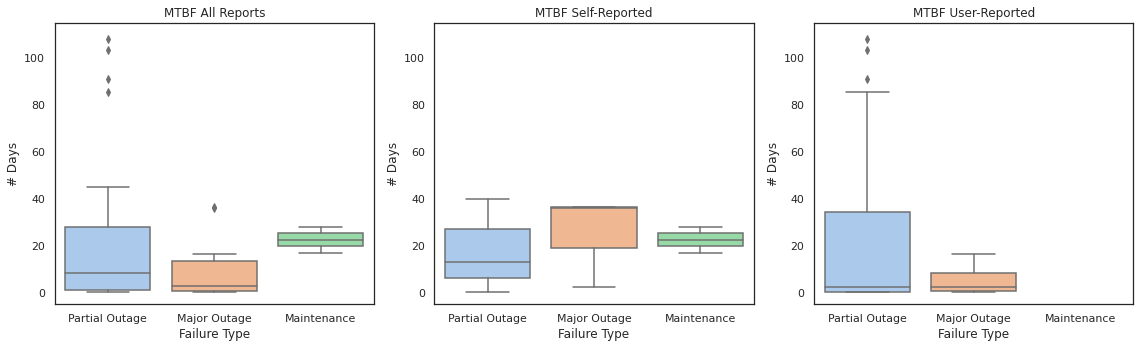

In [57]:
sns.set(rc={'figure.figsize':(16,5)})
sns.set(style='white')
fig, ax = plt.subplots(1,3)
ax0 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(mtbf_plot.set_index('service')), ax=ax[0])
ax1 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(mtbf_plot_self.set_index('service')), ax=ax[1])
ax2 = sns.boxplot(x='variable', y='value', palette='pastel', data=pd.melt(mtbf_plot_user.set_index('service')), ax=ax[2])
ax0.set(title='MTBF All Reports', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Days', ylim=(-5, 115))
ax1.set(title='MTBF Self-Reported', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Days', ylim=(-5, 115))
ax2.set(title='MTBF User-Reported', xticklabels=['Partial Outage', 'Major Outage', 'Maintenance'], xlabel='Failure Type', ylabel='# Days', ylim=(-5, 115))
fig.tight_layout()
plt.savefig('/home/shane/Documents/thesis/output/plots/boxes_mtbf_cmp.pdf')

In [58]:
mtbf_plot.describe()

,mtbf_po,mtbf_mo,mtbf_ma
count,32.000000,13.000000,2.000000
mean,22.594062,9.552308,22.480000
std,31.472185,13.011537,7.806459
min,0.120000,0.120000,16.960000
25%,0.920000,0.830000,19.720000
50%,8.365000,2.680000,22.480000
75%,28.050000,13.520000,25.240000
max,107.900000,36.620000,28.000000


In [59]:
mtbf_plot_self.describe()

,mtbf_po,mtbf_mo,mtbf_ma
count,12.000000,3.000000,2.000000
mean,16.303333,24.943333,22.480000
std,12.487769,19.707248,7.806459
min,0.140000,2.190000,16.960000
25%,6.232500,19.105000,19.720000
50%,13.205000,36.020000,22.480000
75%,27.150000,36.320000,25.240000
max,40.080000,36.620000,28.000000


In [60]:
mtbf_plot_user.describe()

,mtbf_po,mtbf_mo,mtbf_ma
count,21.000000,10.0000,0.0
mean,25.267619,4.9350,NaN
std,37.907797,6.0645,NaN
min,0.120000,0.1200,NaN
25%,0.390000,0.4850,NaN
50%,2.560000,2.3650,NaN
75%,34.380000,8.3275,NaN
max,107.900000,16.3800,NaN
